## PHASE 1: Data Cleaning, Analysis, and Visualization

### Step 1: Load the Data and Inspect It

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\boluw\PYTHON\GOMYCODE\PROJECT\london_merged.csv")

# View data types and check for nulls
print(df.info())
print(df.head())


### Step 2: Check for Missing Values

In [ ]:
# Count missing values
print(df.isnull().sum())

# Optionally drop or fill missing values if found
df = df.dropna()  # or use df.fillna(method='ffill') for forward filling


### Step 3: Convert timestamp to DateTime and Extract Features

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract useful time-based features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday  # Monday = 0


### Step 4: Detect and Handle Outliers



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot to detect outliers
sns.boxplot(data=df[['cnt', 't1', 'hum', 'wind_speed']])
plt.title("Boxplots of Numerical Columns")
plt.show()

# Optionally, remove outliers using IQR
Q1 = df['cnt'].quantile(0.25)
Q3 = df['cnt'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['cnt'] >= Q1 - 1.5 * IQR) & (df['cnt'] <= Q3 + 1.5 * IQR)]


### Step 5: Encode Categorical Features (if any)

The dataset already encodes `season`, `is_holiday`, and `is_weekend` as numerics. If they were strings, you’d do:

In [ ]:
# Example only if you had categorical strings
df['season'] = df['season'].astype('category').cat.codes


### Step 6: Exploratory Data Analysis (EDA)

In [ ]:
# Demand by hour
sns.lineplot(x='hour', y='cnt', data=df.groupby('hour').mean().reset_index())
plt.title('Average Demand by Hour of Day')
plt.show()

# Demand by weekday
sns.barplot(x='weekday', y='cnt', data=df.groupby('weekday').mean().reset_index())
plt.title('Average Demand by Weekday')
plt.show()

# Demand by temperature
sns.scatterplot(x='t1', y='cnt', data=df, alpha=0.3)
plt.title('Demand vs Temperature')
plt.show()

# Correlation heatmap
sns.heatmap(df[['cnt', 't1', 'hum', 'wind_speed', 'hour', 'weekday']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


## Summary of Insights (to document):
- Peak demand occurs during morning and evening hours

- Weekdays vs weekends have noticeable differences

- Temperature and humidity moderately affect ride count

- Strong correlation between `hour` and `cnt` (demand)

---

## PHASE 2: Clustering + Model Building


### Step 1: Feature Selection and Scaling

In [33]:
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
cluster_features = ['hour', 't1', 'hum', 'wind_speed', 'is_weekend', 'season']
X_cluster = df[cluster_features]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


### Step 2: Apply K-Means Clustering

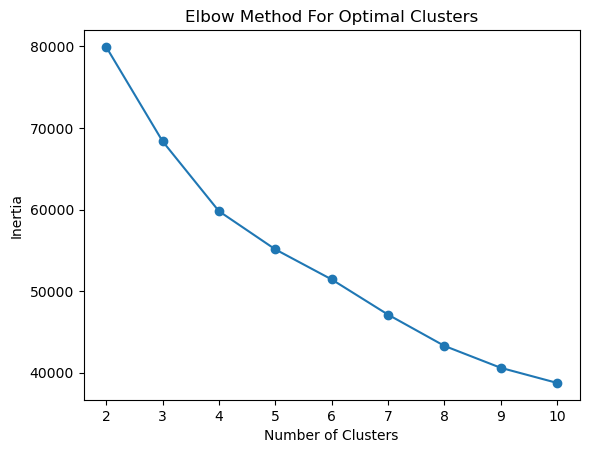

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find best number of clusters
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method For Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Use optimal k (say 4 based on elbow plot)
kmeans = KMeans(n_clusters=4, random_state=0)
df['cluster'] = kmeans.fit_predict(X_scaled)


### Step 3: Visualize Cluster Insights

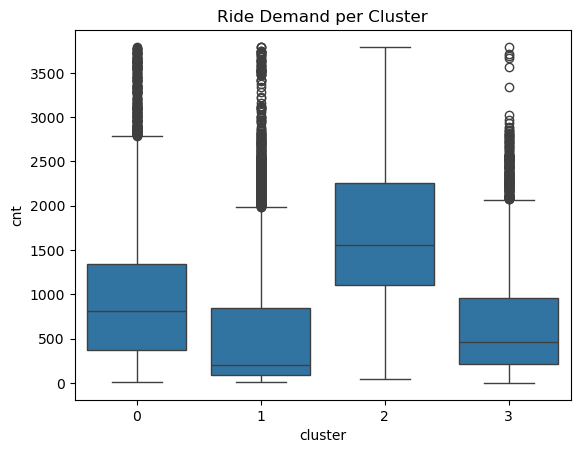

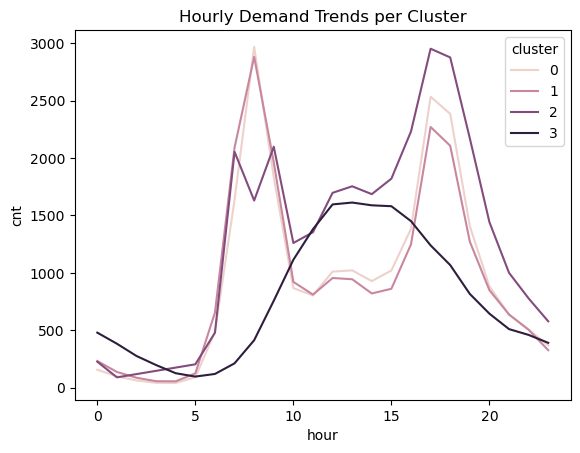

In [38]:
import seaborn as sns

# View cluster-wise demand patterns
sns.boxplot(x='cluster', y='cnt', data=df)
plt.title("Ride Demand per Cluster")
plt.show()

# Average demand by cluster and hour
sns.lineplot(data=df.groupby(['cluster', 'hour'])['cnt'].mean().reset_index(),
             x='hour', y='cnt', hue='cluster')
plt.title("Hourly Demand Trends per Cluster")
plt.show()


### Step 4: Build a Machine Learning Model

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Use features + cluster
features = ['hour', 't1', 'hum', 'wind_speed', 'is_weekend', 'season', 'cluster']
X = df[features]
y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 75564.39
R²: 0.90


### Step 5: Visualize Actual vs Predicted

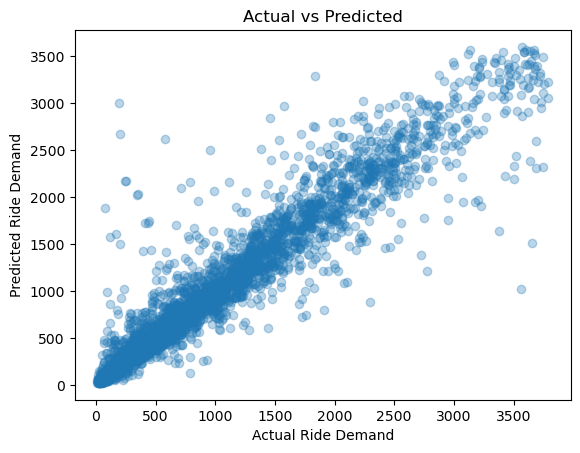

In [46]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Ride Demand")
plt.ylabel("Predicted Ride Demand")
plt.title("Actual vs Predicted")
plt.show()


---

## Phase 3: Model Evaluation and Tuning

### Step 2: Define Evaluation Metrics

In [55]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


### Step 3: Prepare Data

In [58]:
features = ['hour', 't1', 'hum', 'wind_speed', 'is_weekend', 'season', 'cluster']
X = df[features]
y = df['cnt']


### Step 4: Evaluate with Cross-Validation

In [61]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=0),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=0)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    neg_mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    rmse = np.sqrt(-neg_mse).mean()
    results[name] = rmse
    print(f"{name} RMSE (5-fold CV): {rmse:.2f}")


LinearRegression RMSE (5-fold CV): 712.60
RandomForest RMSE (5-fold CV): 276.93
GradientBoosting RMSE (5-fold CV): 351.64


### Step 5: Visualize Model Performance

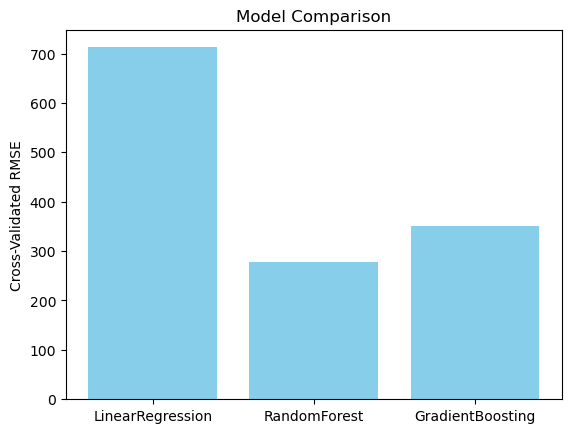

In [63]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
rmse_values = list(results.values())

plt.bar(model_names, rmse_values, color='skyblue')
plt.ylabel("Cross-Validated RMSE")
plt.title("Model Comparison")
plt.show()


### Step 6: Select and Fine-Tune Best Model
Suppose Random Forest wins:

In [65]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid,
                           scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)


Best Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}


### Step 7: Final Evaluation

In [67]:
y_pred = best_model.predict(X)
rmse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Final Model RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Final Model RMSE: 35633.78
MAE: 107.15
R² Score: 0.95
